# Classificador BiLSTM

In [ ]:
import pandas as pd
import re
from sqlalchemy import create_engine
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GridSearchCV

In [ ]:
import keras.metrics as metrics

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [ ]:
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation, Input, Bidirectional
from keras.layers.embeddings import Embedding

### Input Data

In [ ]:
data = pd.read_csv('/work/undergrad-thesis-project/datasets/dataset.csv' )

In [ ]:
data.head()

,term1,term2,relation
0,Casa de Hóspedes,Alojamento,hypo
1,Hostal,Alojamento,hypo
2,Albergue,Alojamento,hypo
3,Pousada,Alojamento,hypo
4,Acomodação,Alojamento,hypo


In [ ]:
data["text"] = data["term1"] +" " + data["term2"]

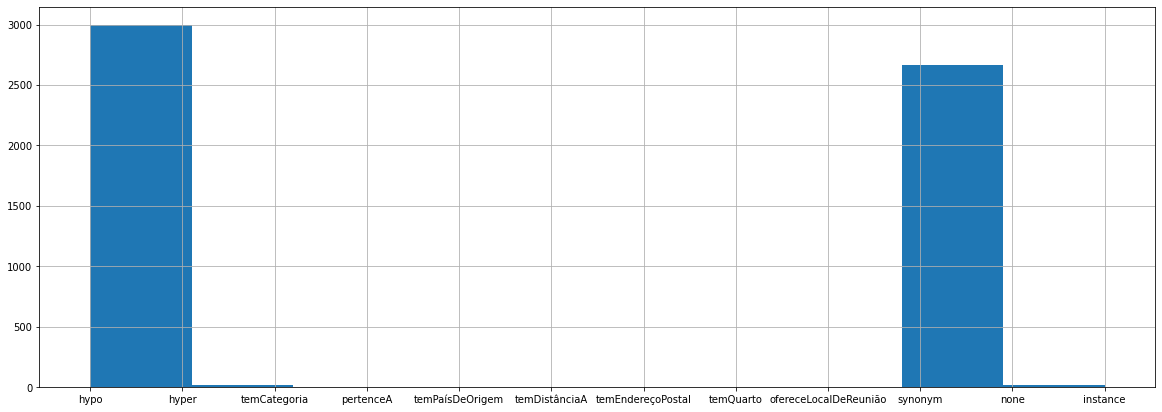

In [ ]:
data['relation'].hist(figsize=(20,7));

In [ ]:
old_labels = ['hypo', 'hyper', 'synonym', 'temCategoria', 'none']
#new_labels = ['Hiponímia', 'Hiperonímia', 'Sinonímia', 'temCategoria', 'sem-relação']
new_labels = [  0,         1,         2,             3,       4]

In [ ]:
count_hypo = 0
count_hyper = 0
count_sym = 0
count_cat = 0
count_none = 0

In [ ]:
for i, row in data.iterrows():
    if(str(row['relation']) == old_labels[0]):
        row['relation'] = new_labels[0]
        count_hypo+=1
    elif(str(row['relation']) == old_labels[1]):
        row['relation'] = new_labels[1]
        count_hyper+=1
    elif(str(row['relation']) == old_labels[2]):
        row['relation'] = new_labels[2]
        count_sym+=1
    elif(str(row['relation']) == old_labels[3]):
        row['relation'] = new_labels[3]
        count_cat+=1
    else:
        row['relation'] = new_labels[4]
        count_none+=1
    #print(type(str(row['term1'])))

In [ ]:
counts = [count_sym, count_hyper, count_hypo, count_cat, count_none]
counts



[2667, 2246, 751, 15, 27]

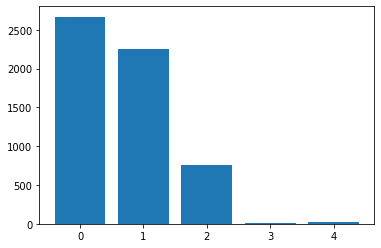

In [ ]:
plt.bar(new_labels, counts, align='center')
plt.gca().set_xticks(new_labels)
plt.show()

In [ ]:
data["relation"] = pd.to_numeric(data["relation"])

In [ ]:
print(data["relation"])

0       0
1       0
2       0
3       0
4       0
       ..
5701    2
5702    2
5703    2
5704    2
5705    2
Name: relation, Length: 5706, dtype: int64


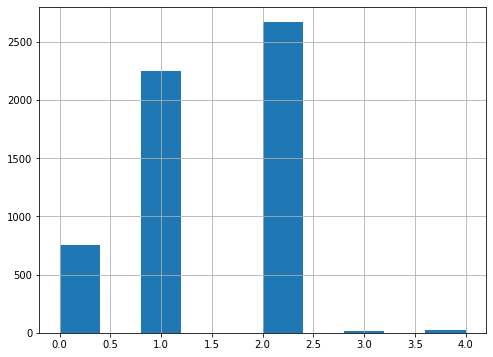

In [ ]:
data['relation'].hist(figsize=(8,6));

In [ ]:
len(data)

5706

### Data Preparation

In [ ]:
nltk.download('stopwords')
stop_words = stopwords.words("portuguese")
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def clean_text(text):
    text = text.lower()
    
    # '@' mention. Even tough @ adds some information to the message, 
    # this information doesn't add value build the classifcation model
    text = re.sub(r'@[A-Za-z0-9_]+','', text)
    
    # Dealing with URL links
    url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    text = re.sub(url_regex,'urlplaceholder', text)
    # A lot of url are write as follows: http bit.ly. Apply Regex for these cases
    utl_regex_2 = 'http [a-zA-Z]+\.[a-zA-Z]+'
    text = re.sub(utl_regex_2,'urlplaceholder', text)
    # Other formats: http : //t.co/ihW64e8Z
    utl_regex_3 = 'http \: //[a-zA-Z]\.(co|com|pt|ly)/[A-Za-z0-9_]+'
    text = re.sub(utl_regex_3,'urlplaceholder', text)
    
    # Hashtags can provide useful informations. Removing only ``#``
    text = re.sub('#',' ', text)
    
    # Contractions
    text = re.sub(r"what's", 'what is ', text)
    text = re.sub(r"can't", 'cannot', text)
    text = re.sub(r"\'s",' ', text)
    text = re.sub(r"\'ve", ' have ', text)
    text = re.sub(r"n't", ' not ', text)
    text = re.sub(r"im", 'i am ', text)
    text = re.sub(r"i'm", 'i am ', text)
    text = re.sub(r"\'re", ' are ', text)
    text = re.sub(r"\'d", ' would ', text)
    text = re.sub(r"\'ll", ' will ', text)
                  
    # Operations and special words           
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub('foof', 'food', text)
    text = re.sub('msg', 'message', text)
    text = re.sub(' u ', 'you', text)
    
    # Ponctuation Removal
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
    
    text = text.split()
    stop_words = stopwords.words("portuguese")
    text = [tok for tok in text if tok not in stop_words]
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(w) for w in text]
    return ' '.join(text)
    

### Tokenize and Create Sentence

In [ ]:
data['text'] = data['text'].astype(str)

In [ ]:
# Cleaning Text
nltk.download('wordnet')
data['text'] = data['text'].map(lambda x: clean_text(x))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


### Chossing size of vocabulary

In [ ]:
vocabulary_size = 20000

In [ ]:
tokenizer = Tokenizer(num_words=vocabulary_size)

In [ ]:
tokenizer.fit_on_texts(data['text'])

In [ ]:
sequences = tokenizer.texts_to_sequences(data['text'])

In [ ]:
print(sequences)

[[202, 80, 729, 10], [17, 10], [11, 10], [20, 10], [7, 10], [24, 10], [730, 731, 10], [8, 732, 10], [5, 10], [733, 134, 10], [221, 182, 287, 10], [10, 155, 592, 10], [8, 10], [4, 10], [361, 34], [41, 416, 734, 34], [156, 45, 34], [34, 34], [27, 34], [18, 18], [288, 202, 73, 18], [31, 47, 18], [288, 6, 18], [362, 735, 18], [31, 83, 18], [30, 18], [76, 1, 183, 76, 1], [76, 1, 92, 76, 1], [76, 1, 184, 83, 76, 1], [76, 1, 184, 489, 76, 1], [76, 1, 76, 1], [15, 61, 62], [59, 593, 61, 62], [736, 61, 62], [61, 62, 61, 62], [48, 61, 62], [50, 61, 62], [43, 61, 62], [59, 417, 737, 61, 62], [49, 61, 62], [738, 739, 61, 62], [32, 61, 62], [44, 61, 62], [53, 61, 62], [51, 60, 61, 62], [363, 417, 740, 61, 62], [59, 361, 61, 62], [157, 61, 62], [33, 61, 62], [58, 58], [58, 6, 58], [58, 29, 58], [58, 182, 58], [58, 364, 58], [58, 36, 58], [58, 183, 58], [58, 365, 58], [58, 182, 287, 58], [40, 26, 89, 63, 1], [63, 1, 741, 89, 63, 1], [2, 89, 63, 1], [63, 1, 490, 145, 89, 63, 1], [63, 1, 365, 89, 63, 1

In [ ]:
sequences.pop(0)

[202, 80, 729, 10]

### Pads sequences to the same length: MAXLEN

In [ ]:
MAXLEN = 300
X = pad_sequences(sequences, maxlen=MAXLEN)


In [ ]:
output_columns_all = ['relation']
y = data['relation']
y.pop(0)

0

In [ ]:
y

1       0
2       0
3       0
4       0
5       0
       ..
5701    2
5702    2
5703    2
5704    2
5705    2
Name: relation, Length: 5705, dtype: int64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state = 42)

In [ ]:
print(len(X_train),len(X_test))

4849 856


### Creating RNN

The majority of the classes are binary, but one of them has 5 different classes. Because of that, the model will be divided into two different types of outputs: - binary - sparse category: The output has integer targets, and differently from catergorical crossentropy, the target doens't need to be one-hot encoded

Since the dataset is highly imblanced, I applied a class weight in order to try to balance the model prediction. Keras contains the class_weight paramater, but as related into this&nbsp;issue&nbsp;on Keras, I came into the same bug. When you apply the class_weight paramter for a Multi Label Classification problem, keras throws the following error:

560 if sample_weight_mode is None:

ValueError:&nbsp;class_weight&nbsp;must contain all classes in the data. The classes {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 23, 30, 31, 32, 33, 34, 35, 36} exist in the data but not in&nbsp;class_weight.

The solution that I came up with was to create multiple outputs, one for every binary class, and another for the sparse category class.

In [ ]:
output_columns_categorical = ['relation']

In [ ]:
output_array = []
metrics_array = {}
loss_array = {}


## Word Embeddings&nbsp;Test

The embedding size will be the same as before: MAXLEN=50

In [ ]:
MAXLEN2 = 50

In [ ]:
!ls /datasets/moni-drive/WE/wang2vec_cbow_s50.txt

/datasets/moni-drive/WE/wang2vec_cbow_s50.txt


In [ ]:
embeddings_index = dict()
f = open('/work/undergrad-thesis-project/models/teste.txt')
for line in f:
    values = line.split()
    word = values[0]
    for n, i in enumerate(values[1:]):
        values[n] = values[n].replace(',', '.')
        if "%" in values[n]: 
            values.pop(n)
    try:
        coefs = np.asarray((values[1:]), dtype='float32')
        embeddings_index[word] = coefs
    except:
        continue
f.close()
    

In [ ]:
embedding_matrix = np.zeros((vocabulary_size, MAXLEN))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    
    if index > vocabulary_size - 1:
        break
    
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            #print(embedding_matrix[index].shape)
            if (embedding_vector.shape != (51,)):
                embedding_matrix[index] = embedding_vector
            #break
            

In [ ]:
main_input = Input(shape=(MAXLEN,), dtype='int32', name='main_input')


In [ ]:
!pip install gensim==4.0.1

     |████████████████████████████████| 23.9 MB 11.1 MB/s 


In [ ]:

import gensim.models.keyedvectors as word2vec
wang_model = word2vec.KeyedVectors.load_word2vec_format('/work/undergrad-thesis-project/tripAdvisor/models/wang2vec-cwindow.model', binary=True, encoding='utf-8')



/root/venv/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [ ]:
#x = wang_model.save_word2vec_format('teste.txt')

In [ ]:
x = Embedding(vocabulary_size, MAXLEN, weights=[embedding_matrix], input_length=MAXLEN, trainable=False)(main_input)

In [ ]:
x = Dropout(0.5)(x)

In [ ]:
x = Conv1D(64, 5, activation='relu')(x)

In [ ]:
x = MaxPooling1D(pool_size=4)(x)

In [ ]:
x = Bidirectional(LSTM(200))(x)

In [ ]:
x = Dropout(0.5)(x)

In [ ]:
#output
categorical_output = Dense(5, activation='softmax', name='categorical_output')(x)
output_array.append(categorical_output)
metrics_array['categorical_output'] = 'sparse_categorical_accuracy'
loss_array['categorical_output'] = 'sparse_categorical_crossentropy'

In [ ]:
model = Model(inputs=main_input, outputs=categorical_output)

In [ ]:
model.compile(optimizer='adadelta',
              loss=loss_array,
              metrics=metrics_array)

In [ ]:
y_train_output = []


y_train_output.append(y_train)

In [ ]:
history_train = model.fit(X_train, y_train_output,
          epochs=20, batch_size=512, verbose=0);

## Evaluation: Accuracy and Loss

In [ ]:
history_test =  model.evaluate(X_test, y_test, batch_size=128)


7/7 [==============================] - 6s 723ms/step - loss: 1.6053 - sparse_categorical_accuracy: 0.4661


In [ ]:
history_test

[1.6053334474563599, 0.46612149477005005]

### Model Evaluation

### Test

In [ ]:

y_pred = model.predict(X_test)

In [ ]:
THRESHOLD = 0.9 # threshold between classes

In [ ]:
f1_score_results = []
#for col_idx, col in enumerate(output_columns_categorical):

print(f'Relation accuracy \n')

# Select class with higher probability from the softmax output: 0, 1 or 2
y_pred_2 = np.argmax(y_pred, axis=-1)
f1_score_results.append(f1_score(y_test, y_pred_2, average='macro'))
print(classification_report(y_test, y_pred_2))
print('Total :',np.sum(f1_score_results))

Relation accuracy 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       108
           1       0.56      0.01      0.03       348
           2       0.47      0.99      0.63       396
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         3

    accuracy                           0.47       856
   macro avg       0.20      0.20      0.13       856
weighted avg       0.44      0.47      0.30       856

Total : 0.1323922650315154
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-sco

In [ ]:
history_train

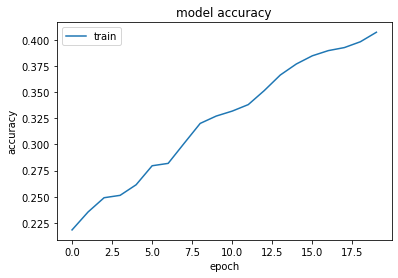

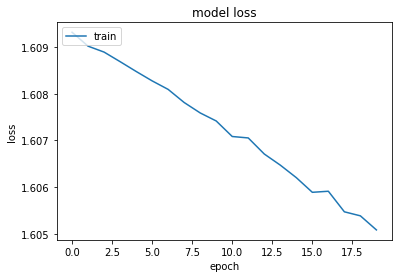

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history_train.history['sparse_categorical_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history_train.history['loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
cm_pred = np.argmax(y_pred, axis=1)
cm_test = np.argmax(y_test, axis=0)

In [ ]:
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(y_test, cm_pred)

In [ ]:
print(matrix)

[[  0   2 106   0   0]
 [  0   5 343   0   0]
 [  0   2 394   0   0]
 [  0   0   1   0   0]
 [  0   0   3   0   0]]


In [ ]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Purples')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('Correct Class')
    plt.xlabel('Predicted Class nAccuracy={:0.4f}'.format(accuracy))
    plt.show()

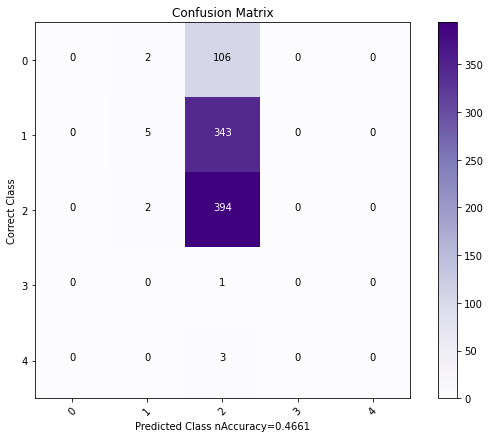

In [ ]:
plot_confusion_matrix(matrix, 
                      normalize    = False,
                      target_names = ['0', '1', '2', '3', '4'],
                      title        = "Confusion Matrix")


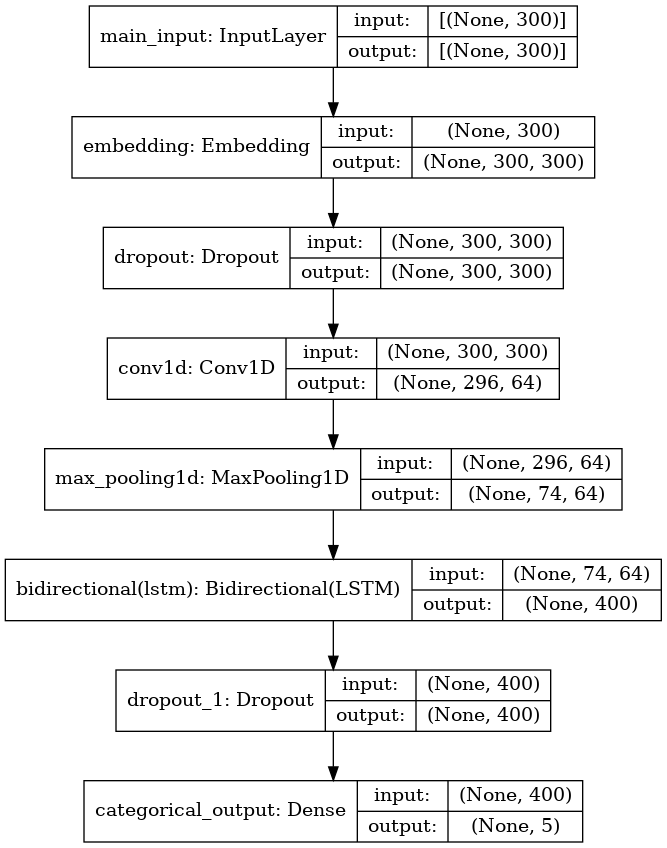

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c82c7d35-a90b-41fd-a2db-0e7ec7cbd041' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>